## Used resources for Schunk development

### CAN resources 

* [How to use ros-canopen](https://answers.ros.org/question/233735/how-to-used-ros_canopen/)   
* [canopen_test_utils](https://github.com/ipa320/canopen_test_utils)     
* [schunk_lwa4p_canopen](https://github.com/jlarraez/schunk_lwa4p)    
* [ros_canopen overview](http://wiki.ros.org/ros_canopen)  
* [canopenchain_node_overview](http://wiki.ros.org/canopen_chain_node)   
* [CanOpenBUSLayer](http://wiki.ros.org/canopen_chain_node#Configuration)
* [CANOpen ROS package getting started](https://community.husarion.com/t/canopen-ros-package-getting-started/475/2) 

#### TODO: 
 - [ ] Add special CAN primer on github page

Very good presentation about rosbag api can be found [here](https://www.fer.unizg.hr/_download/repository/lec08-rosbag-ipython.pdf).

In [9]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd

## How to setup virtual environment? 

You can setup `virtualenv` quite easily by following instructions on following [link](https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/26/python-virtual-env/) 

### How to activate virtual environment? 

Run following command inside folder in which you have created virtual environment as follows: `source <virtualenv_name>/bin/activate` 

After that you can use `pip3 install <package_name>` to install neccessary python packages. 

## Read bag

In [8]:
bag_name = "2021-07-21-14-23-43.bag"

b = bagreader(bag_name)

[INFO]  Successfully created the data folder 2021-07-21-14-23-43.


### Insert data into csv_files

In [265]:
csv_files = []
for topic in b.topics:
    #print(topic)
    data = b.message_by_topic(topic)
    csv_files.append(data)

In [254]:
joint_group_position_ctl_cmd = pd.read_csv(csv_files[0])
joint_states = pd.read_csv(csv_files[1])

### How to plot pandas dataframe with matpotlib? 

Instructions for plotting pandas dataframe with matplotlib can be found [here](https://pandas.pydata.org/pandas-docs/version/0.13/visualization.html)

More documentation about plotting matplolib can be found [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) 

In [266]:
#methods for exploring dataframe
#print(type(joint_states))
#print(joint_states)
#print(dir(joint_states))
#print(joint_states['position_0'])
#print(type(joint_states['position_0'])) # Just one column is Series which is quite suitable for plotting

In [267]:
#print(joint_group_position_ctl_cmd)
#print(dir(joint_group_position_ctl_cmd))

# Development ideas: 
- [x] simple plot series method 
- [ ] complicated plot series metod (assertions, legend, grid, time plotting)
- [ ] plot multiple series method 
- [ ] align two measurements taken time in cosideration (added start_truncation, but end doesn't work) 

In [268]:
def plot_series(time, series, scale_time=False):
    plt.figure()
    assert(len(time) == len(series)), "Please check your data lengths"        
    
    #if use_sim_time = False 
    if scale_time:
        time = [t - time[0] for t in time]
        
    plt.plot(time, series)
    plt.grid(color='0.95')
    plt.title('{}'.format(series.name))
    plt.show()
    
        
    

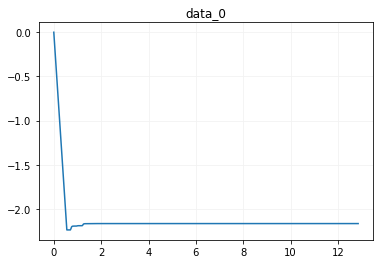

In [269]:
plot_series(joint_group_position_ctl_cmd["Time"], joint_group_position_ctl_cmd['data_0'], scale_time=True)

In [270]:
def get_series_by_key_from_df(dataframe, key):
    series_list = []
    for column in dataframe.columns:
        if key in str(column): 
            series_list.append(dataframe["{}".format(column)])
    return series_list

In [271]:
#print(dir(joint_group_position_ctl_cmd))
#print(joint_group_position_ctl_cmd.info())
#print(joint_group_position_ctl_cmd.columns)

In [272]:
config_dict = {"title":"graph",
               "x_label":"t [s]",
               "y_label": "joint_cmd [rad]",
               "w": 7,
               "h": 6,
               "grid": True,
               "use_legend":True}

def plot_multiple_series(time, series_list, series_names = None, config_dict = None, scale_time=False):
    """
        time: pandas series for time 
        series_list: list containing pandas series
        series_names: list containing names for each series that's going to be plotted
        config_dict: dictionary containing config params
        scale_time: boolean for scaling time to 0-duration scale (if not use_sim_time active)
    
    """
    
    if config_dict: 
        title = config_dict['title']
        x_label = config_dict['x_label']
        y_label = config_dict['y_label']
        width, height = config_dict['w'], config_dict['h']
        use_legend = config_dict['use_legend']
        grid = config_dict['grid']
        f_size = config_dict['font_size']
        
    else:
        title="graph"
        x_label = "t"
        y_label = "data"
        width, height = 5, 5
        use_legend = False
        grid = False
    
    # Create figure
    plt.figure(figsize=(width, height))
    # Check if len of time is same as len of series (plotting condition)
    for series in series_list:
        assert(len(time) == len(series)), "Please check one of your series from series list"
    
    # Scale time to secs if use_sim_time=False (e.g. real_robot)
    if scale_time:
        time = [t - time[0] for t in time]    
        
    # Plot series 
    # https://www.geeksforgeeks.org/matplotlib-pyplot-legend-in-python/
    if use_legend: 
        for series_name, series_value in zip(series_names, series_list):
            plt.plot(time, series_value, label=series_name)
    else:
        for series_value in series_list:
            plt.plot(time, series_value)
    
    if grid: 
        plt.grid(color="0.95")
    if use_legend: 
        plt.legend(loc ="best")
        
    plt.title(title, fontsize=round(1.2*f_size))
    plt.xlabel(x_label, fontsize=f_size)
    plt.ylabel(y_label, fontsize=f_size)
        
    plt.show()

### Plot joint cmd positions

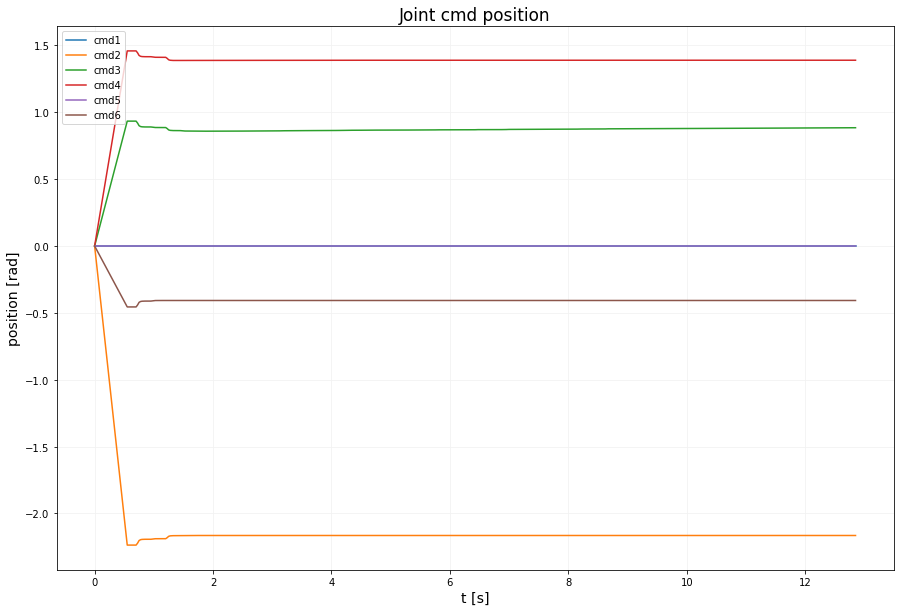

In [262]:
time = joint_group_position_ctl_cmd["Time"]
series_names = ['cmd1', 'cmd2', 'cmd3', 'cmd4', 'cmd5', 'cmd6']
series_list = get_series_by_key_from_df(joint_group_position_ctl_cmd, "data")

config_dict = {
               "title":"Joint cmd position", 
               "x_label":"t [s]",
               "y_label": "position [rad]",
               "w": 15,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
               "grid_x":True, 
                
              }

plot_multiple_series(time, series_list, series_names, config_dict, scale_time=True)

### Plot joint states positions

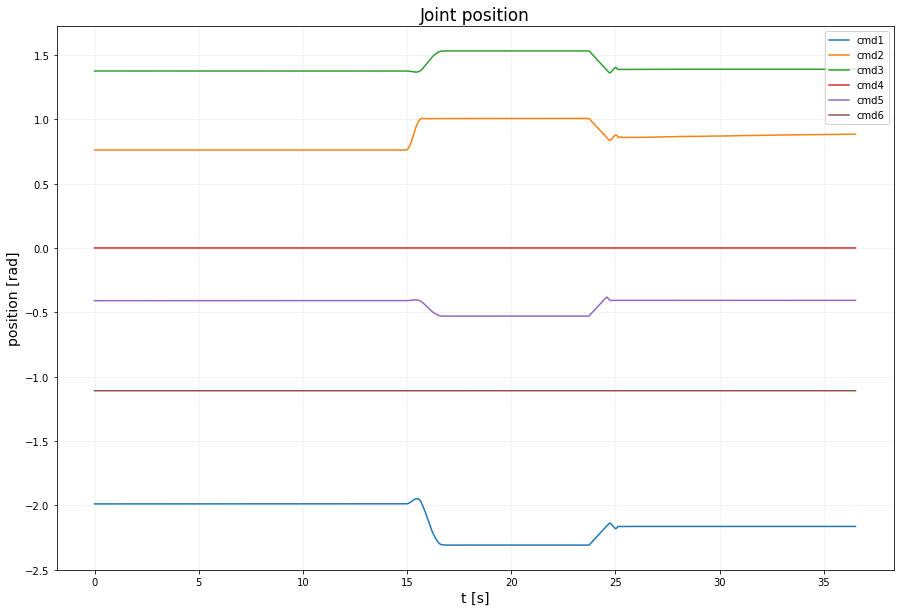

In [273]:
joint_states = pd.read_csv(csv_files[1])
time = joint_states['Time']
series_list = get_series_by_key_from_df(joint_states, "position")

config_dict = {
               "title":"Joint position", 
               "x_label":"t [s]",
               "y_label": "position [rad]",
               "w": 15,
               "h": 10,
               "use_legend":True,
               "font_size": 14, 
               "grid":True, 
              }

plot_multiple_series(time, series_list, series_names, config_dict, scale_time=True)


## Crop one list to another

Idea is to check how does manipulation servoing follows reference. Servoing reference lasts only when action server is active, 
therefore it's not possible to correctly compare joint states.

In [406]:
def scale_time(time):    
    scaled_time = pd.Series([t - time[0] for t in time])    
    return scaled_time

# They're not subset because time is not so correct
def check_if_subset(s1, s2):
    res = s1.isin(pd.to_numeric(s2, errors='coerce')).all()
    return res

# Get servoing start time
def get_start_end_time(time):
    start_time, end_time = time.values[0], time.values[-1]
    return start_time, end_time

def get_frequency(time):
    
    time = [t - t[0] for t in time]
    frequency = max(time)/len(time)
    return frequency
    
    

In [317]:
time_s = joint_states['Time']
time_s_cmd = joint_group_position_ctl_cmd['Time']

In [348]:
# Scale time to 0 to duration 
scaled_time_s = scale_time(time_1)
scaled_time_s_cmd = scale_time(time_2)

# Get start and end in cmd 
start_t_cmd, end_t_cmd = get_start_end_time(time_s_cmd)

# Get start :) 
diff_list = [t - start_t_cmd for t in time_s]

closest_element = min([t if t > 0 else 1000 for t in diff_list])

# Find out closest element in mesurements 
index_ = list(time_s).index(closest_element + start_t_cmd)
print("Start index is: {}".format(index_))
print("Servoing length is: {}".format(len(scaled_time_s_cmd)))
print("Measurement length is: {}".format(len(scaled_time_s)))

Start index is: 948
Servoing length is: 494
Measurement length is: 1462


In [322]:
print(scaled_time_1[1])
print(scaled_time_2[1])

0.024976015090942383
0.5508368015289307


In [403]:
def crop_dfs(t_s1, t_s2, df_1, df_2):
    """
        t_s1: pd Series of longer time 
        t_s2: pd Series of shorter time
        df_1: dataframe of longer time
        df_2: dataframe of shorter time
        
        Condition is that both measurements are in same frequency. 
    
    """
    
    debug_info = True
    if debug_info:
        print("t1 len: {}".format(len(t_s1)))
        print("df1 len: {}".format(len(df_1)))
        print("t2 len: {}".format(len(t_s2)))
        print("df2 len: {}".format(len(df_2)))
    
    # Get start and end time
    start_t_cmd, end_t_cmd = get_start_end_time(t_s2)
    
    print(end_t_cmd, print(t_s2.values[-1]))
    
    # Get times in relation to start time and end_time of servoing
    start_diff_list = [t - start_t_cmd for t in t_s1]
    end_diff_list = [t - end_t_cmd for t in t_s1]
          
    print(end_diff_list)
    
    # Find closest start element
    closest_start_element = min([t if t > 0 else 1000 for t in start_diff_list])
    
    # Find closest end element
    closest_end_element = min([t if t > 0 else 1000 for t in end_diff_list])
    
    # Find out index of a closest element
    start_index_ = list(time_s).index(closest_start_element + start_t_cmd)    
    end_index_ = list(time_s).index(closest_end_element + end_t_cmd)
    
    print("Closest start index is: {}".format(start_index_))
    print("Closest end index is: {}".format(end_index_))
    
    # Truncate https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.truncate.html
    t_s1 = t_s1.truncate(before = start_index_)
    df_1 = df_1.truncate(before = start_index_)
    
    return t_s1, t_s2, df_1, df_2

In [407]:
time_s = joint_states['Time']
time_s_cmd = joint_group_position_ctl_cmd['Time']
joint_group_position_ctl_cmd = pd.read_csv(csv_files[0])
joint_states = pd.read_csv(csv_files[1])
time_s, time_s_cmd, joint_states, joint_group_position_ctl_cmd = crop_dfs(time_s,
                                                                          time_s_cmd,
                                                                          joint_states,
                                                                          joint_group_position_ctl_cmd)

print("cmd freq is: {}".format(time_s_cmd))
print("meas freq is: {}".format(time_s))

t1 len: 1462
df1 len: 1462
t2 len: 494
df2 len: 494
1626870260.5753016
1626870260.5753016 None
[-36.52592372894287, -36.50094771385193, -36.47608780860901, -36.45095205307007, -36.42568612098694, -36.40075206756592, -36.37583303451538, -36.35091853141785, -36.325955629348755, -36.300716400146484, -36.27557063102722, -36.25062012672424, -36.22559356689453, -36.201042890548706, -36.175623178482056, -36.1507728099823, -36.125988483428955, -36.10082674026489, -36.0758376121521, -36.05114769935608, -36.02574014663696, -36.000739336013794, -35.97573661804199, -35.95070195198059, -35.925846338272095, -35.9009792804718, -35.876107931137085, -35.851094484329224, -35.82598686218262, -35.8009991645813, -35.77600407600403, -35.75099539756775, -35.72572302818298, -35.70063376426697, -35.67611050605774, -35.65058493614197, -35.62600755691528, -35.601014375686646, -35.57562875747681, -35.55070090293884, -35.525702476501465, -35.500752687454224, -35.476003885269165, -35.45110058784485, -35.42595171928

ValueError: 1626871260.5753016 is not in list

In [405]:
print(len(time_s))
print(len(time_s_cmd))
print(len(joint_states))

1462
494
1462
